In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import line_search
plt.rcParams["figure.figsize"] = (20, 10)

EPS = 1e-6
MAX_EPOCH = 100000


def distance(x, y):
    return np.linalg.norm(x - y)


class Function:
    def __init__(self, function, grad, min_point=(0, 0)):
        self.call = function
        self.grad = grad
        self.min_point = min_point

    def __call__(self, point):
        return self.call(point)

    def grad(self, point): return self.grad(point)    


def make_point(x, y): return np.array((x, y))

def draw_function(f):
    t = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(t, t)
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(x, y, f((x, y)))

def draw_gradient(f, points):
    colors = ['b', 'g', 'm', 'c', 'orange']
    t = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(t, t)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(f((points[:, 0], points[:, 1])), lw=2, color=colors[0], )
    ax1.grid()

    Z = f([X, Y])
    cp = ax2.contourf(X, Y, Z)
    fig.colorbar(cp)
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='r')

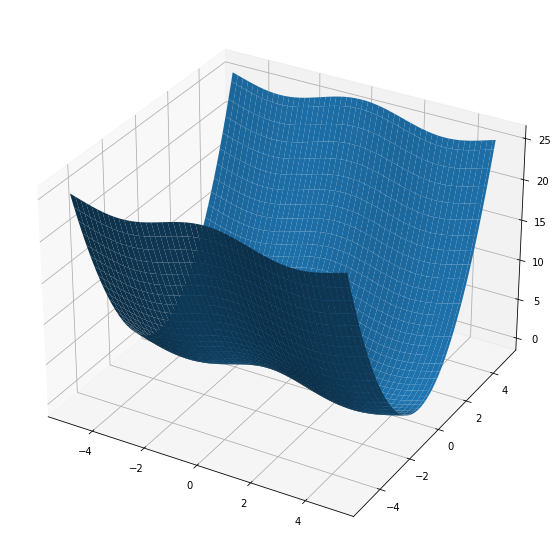

In [2]:
def cosy2(point):
    x, y = point
    return np.cos(x) + y ** 2


def grad_cosy2(point):
    x, y = point
    return make_point(-np.sin(x), 2 * y)


fun = Function(cosy2, grad_cosy2, np.array((math.pi, 0)))
draw_function(fun)

__Задание 1__

In [3]:
def abstract_gradient_descent(first_point, next_point_fun, stop_criteria):
    points = np.array([first_point])
    x = first_point
    epoch = 0
    while not stop_criteria(x) and epoch < MAX_EPOCH:
        x = next_point_fun(x, epoch)
        points = np.append(points, [x], axis=0)
        epoch += 1
    return points


def stop_by_grad(f):
    return lambda x: np.linalg.norm(f.grad(x)) < EPS


def lin_rate_grad_descent(f, first_point, lin_rate):
    next_point = lambda x, epoch: x - lin_rate(epoch) * np.array(f.grad(x))
    return abstract_gradient_descent(first_point, next_point, stop_by_grad(f))

Посмотрим, за сколько шагов наш градиентный спуск приходит к минимуму в зависимости от параметра linear_rate

In [4]:
def test_const_lin_rate(f, first_point, grad_descent, test_list):
    def run(lr):
        return grad_descent(f, first_point, lambda _: lr)

    ans = pd.DataFrame()
    ans["Linear rate"] = test_list
    ans["Epochs"] = list(map(len, map(run, test_list)))
    return ans


lin_rate_test_list = list(i for i in np.arange(0.2, 1, 0.1))
test_const_lin_rate(fun, make_point(2, 1), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.2,65
1,0.3,41
2,0.4,29
3,0.5,22
4,0.6,17
5,0.7,17
6,0.8,30
7,0.9,67


__Задание 2__

In [5]:
def exp_lin_rate_grad_descent(f, first_point, d):
    return lin_rate_grad_descent(f, first_point, lambda epoch: np.exp(-d * epoch))


def test_exp_lin_rate(f, first_point, test_list):
    def run(d):
        return exp_lin_rate_grad_descent(f, first_point, d)

    ans = pd.DataFrame()
    ans["d"] = test_list
    ans["Epochs"] = list(map(len, map(run, test_list)))
    return ans


exp_lin_rate_test_list = list(i for i in np.arange(0.05, 0.10, 0.005))
test_exp_lin_rate(fun, make_point(2, 1), exp_lin_rate_test_list)

,d,Epochs
0,0.050,15
1,0.055,15
2,0.060,14
3,0.065,13
4,0.070,12
5,0.075,12
6,0.080,13
7,0.085,14
8,0.090,15
9,0.095,17


__Задание 3__
Улучшим наш градиентный спуск с помощью дихотомии:

12

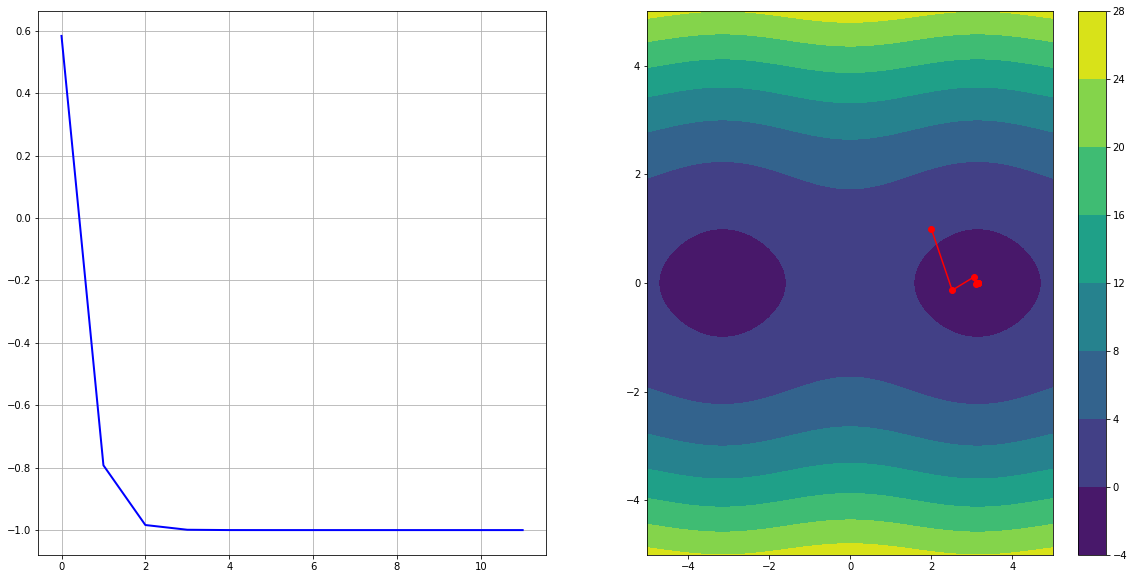

In [6]:
def dichotomy_constructor(left_bound, right_bound, delta, dichotomy_map=lambda x: x):
    def dichotomy(f):
        left = left_bound
        right = right_bound
        x = left
        while right - left >= EPS:
            x = (left + right) / 2
            if f(x - delta) <= f(x + delta):
                right = x
            else:
                left = x
        return dichotomy_map(x)

    return dichotomy


def dichotomy_grad_descent_constructor(left_bound, right_bound, delta):
    def impl(f, first_point):
        dichotomy = dichotomy_constructor(left_bound, right_bound, delta)

        def next_point_fun(x, epoch):
            d = dichotomy(lambda a: f(x - a * f.grad(x)))
            return x - d * f.grad(x)

        return abstract_gradient_descent(first_point, next_point_fun, stop_by_grad(f))

    return impl


dichotomy_grad_descent = dichotomy_grad_descent_constructor(-1, 1, 0.02)
ps = dichotomy_grad_descent(fun, make_point(2, 1))
draw_gradient(fun, ps)
len(ps)

In [7]:
t = fun.grad(make_point(2, 1)) ** 2
np.dot(t, t)

16.68363430620573

__Задание 4__
Применим к полученному алгоритму усиленные условия Вольфе  
  
![alt text](Wolphe.png)    
  
Первое неравенство отвечает за уменьшение функции после совершения шага, второе неравенство -- за уменьшение проекции градиента по модулю, чтобы не допустить точек далеких от стационарных  
Как правило : $c_1 = 0.0001$, $c_2 = 0.9$


12

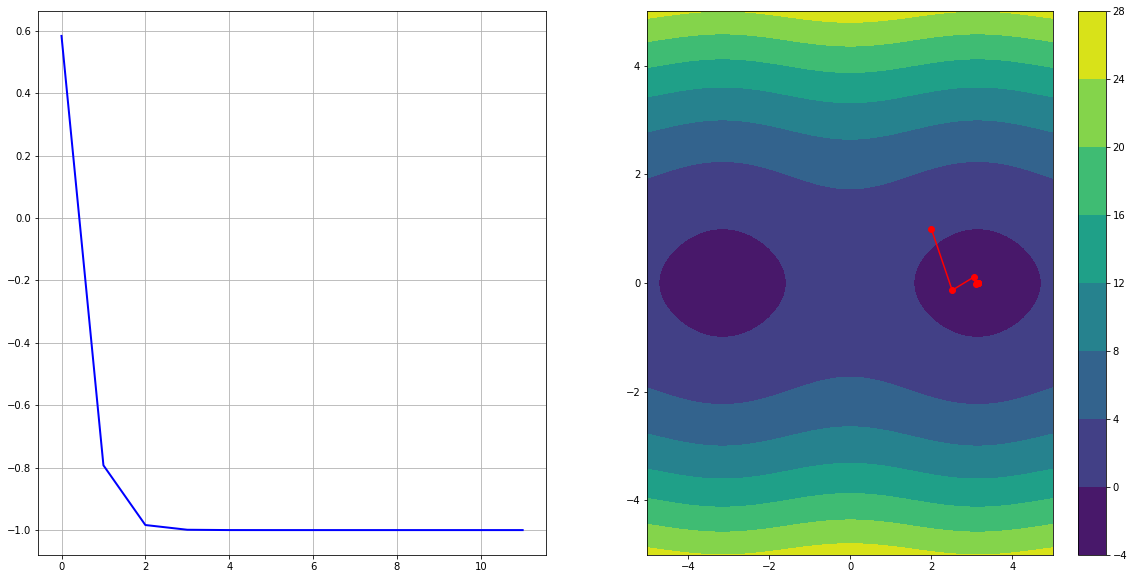

In [8]:
def Wolfe_grad_descent_constructor(left_bound, right_bound, delta):
    def impl(f, first_point):
        def next_point_fun(x, epoch):
            def check_Wolfe(alpha):
                fun_grad = f.grad(x)
                return (f(x - alpha * fun_grad) <= f(x) - C1 * alpha * np.dot(fun_grad, fun_grad) and
                        np.dot(f.grad(x - alpha * fun_grad), fun_grad) <= C2 * np.dot(fun_grad, fun_grad))

            def Wolphe_map(alpha):
                eps = 0
                global C1 
                C1 = 1e-4
                global C2
                C2 = 0.9
                for i in range(MAX_EPOCH):
                    alpha_left = alpha - eps
                    alpha_right = alpha + eps
                    if check_Wolfe(alpha_right):
                        return alpha_right
                    if check_Wolfe(alpha_left):
                        return alpha_left
                    else:
                        eps = eps + 0.001 if eps == 0 else eps * 2

            dichotomy = dichotomy_constructor(left_bound, right_bound, delta, dichotomy_map=Wolphe_map)


            d = dichotomy(lambda a: f(x - a * f.grad(x)))
            return x - d * f.grad(x)

        return abstract_gradient_descent(first_point, next_point_fun, stop_by_grad(f))

    return impl


Wolfe_grad_descent = Wolfe_grad_descent_constructor(-1, 1, 0.02)
ps = Wolfe_grad_descent(fun, make_point(2, 1))
draw_gradient(fun, ps)
len(ps)

__Задание 5__

In [9]:
def test_func(func):
    draw_function(func)
    common_lin_rate = 0.55
    points = lin_rate_grad_descent(fun1, make_point(4.5, 0), lambda _: common_lin_rate)
    draw_gradient(func, points)
    print('number of points:', len(points))


number of points: 39
number of points: 39


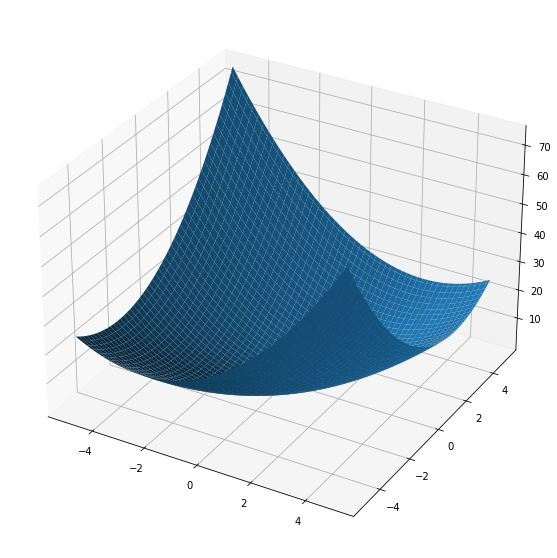

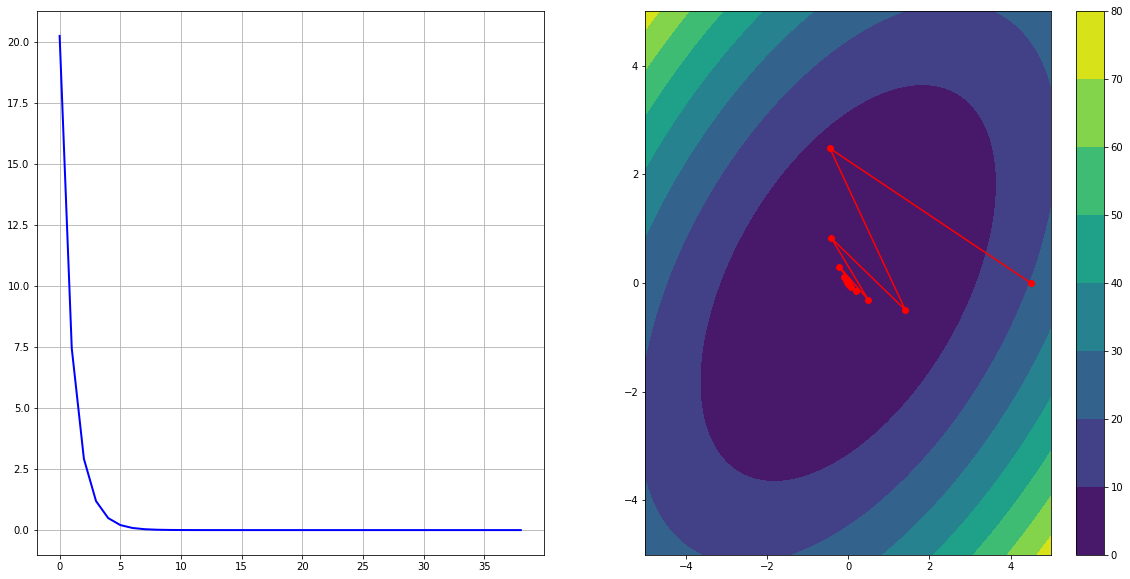

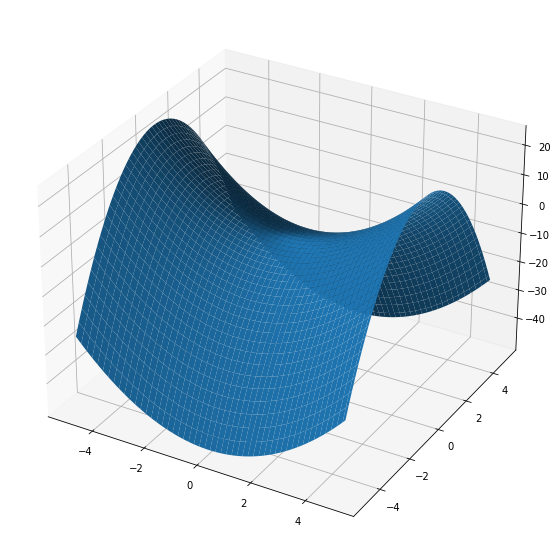

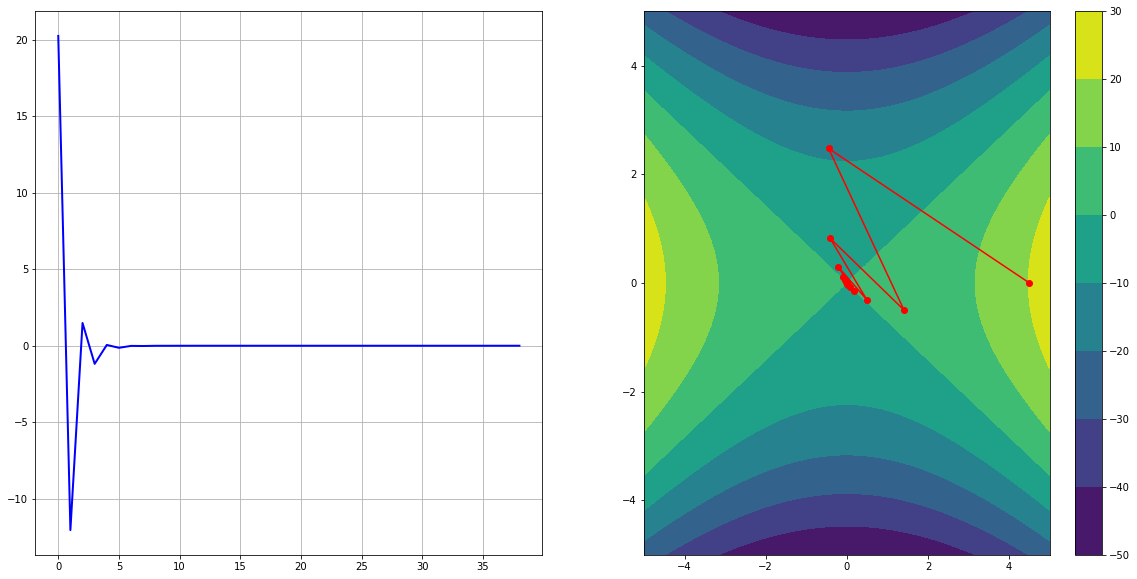

In [10]:
def func1(point):
    x, y = point
    return x**2 + y**2 - x * y
def grad1(point):
    x, y = point
    return make_point(2*x - y, 2*y - x)
fun1 = Function(func1, grad1, np.array((0, 0)))

test_func(fun1)


def func2(point):
    x, y = point
    return x**2 - 2 * y**2

def grad2(point):
    x, y = point
    return make_point(2*x, -4*y)
fun2 = Function(func2, grad2, np.array((0, 0)))

test_func(fun2)

In [11]:
lin_rate_test_list = np.arange(0.1, 0.7, 0.05)
test_const_lin_rate(fun1, make_point(4.5, 0), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.10,144
1,0.15,94
2,0.20,69
3,0.25,54
4,0.30,43
5,0.35,36
6,0.40,31
7,0.45,27
8,0.50,25
9,0.55,39


In [12]:
test_const_lin_rate(fun2, make_point(4.5, 0), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.10,73
1,0.15,46
2,0.20,33
3,0.25,25
4,0.30,19
5,0.35,15
6,0.40,11
7,0.45,8
8,0.50,2
9,0.55,8


<h2>Лабораторная №2, стохастический градиентный спуск</h2>

<h5>Задание 1</h5>

In [13]:
import random
from enum import Enum

def get_average_value(array):
    return np.mean(array)

def get_deviation(array):
    return np.std(array)

def get_normalized_points(array):
    average =  get_average_value(array)
    deviation =  get_deviation(array)
    return np.array([(x - average) / deviation for x in array])

class Mode(Enum):
     POINTS_ON_LINE = 1
     RANDOM_POINTS = 2

class Linear_Regression:
    def __init__(self, fr : int, to : int, mode : Mode, is_normalized : bool, number : int):
        self.painter = Draw(fr, to, is_normalized)
        if mode == Mode.POINTS_ON_LINE:
            points_array = self.painter.draw_line_points(number, 2, 1);
        else: 
            points_array = self.painter.draw_random_points(number)        
        self.points = np.stack(points_array, axis = 1)
        tmp_array = np.array([point[0] for point in self.points])
        self.average_x = get_average_value(tmp_array)
        self.deviation_x = get_deviation(tmp_array)
        self.gradients = []
        for point in self.points:
            self.gradients.append(Linear_Regression.create_gradient(point))     
        self.func = lambda linear: sum((linear[0] * point[0] + 
        linear[1] - point[1]) ** 2 for point in self.points)

    def __call__(self, point):
        self.func(point)        
        
    @staticmethod
    def create_gradient(point):
        x, y = point
        def func(point_):
            a, b = point_
            return [2 * (a * x + b - y) * x, 2 * (a * x + b - y)]
        return func    

    def sample_gradient(self, n):
        def grad_selected(point):
            grad = np.array((0, 0)) 
            selected = random.sample(self.gradients, k=n)
            for selection in selected:
                grad = grad + selection(point)
            return grad
        return grad_selected

    def get_Function(self, n):
        return Function(self.func, self.sample_gradient(n), make_point(0, 0))

    def get_points_number(self):
        return len(self.points)

    def get_full_Function(self):
        return Function(self.func, self.sample_gradient(self.get_points_number()), make_point(0, 0))    
        
    def stoch_grad_descent(self, fun, first_point, lin_rate_test_list):
        lines = []
        for lr in lin_rate_test_list:
            k, m = lin_rate_grad_descent(fun, first_point, lambda _: lr)[-1] 
            self.painter.draw_straight_line(k, m, self.average_x, self.deviation_x)
            lines.append(make_point(k, m))
        return (lines, test_const_lin_rate(fun, first_point, lin_rate_grad_descent, lin_rate_test_list)["Epochs"])    

    def test_stoch_grad(self, first_point, lin_rate_test_list):    
        fun = linear.get_Function(1) # use 1 summand to count gradient
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def test_minibatch(self, first_point, lin_rate_test_list, k):
        assert 2 <= k < linear.get_points_number() 
        fun = linear.get_Function(k) 
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def test_grad(self, first_point, lin_rate_test_list):
        fun = self.get_Function(linear.get_points_number())
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def get_table(self, first_point, lin_rate_test_list, num_minibatch):
        full_fun = self.get_full_Function()
        ans = pd.DataFrame()
        ans["Linear rate"] = lin_rate_test_list
        SGD_lines, SGD_epochs = self.test_stoch_grad(first_point, lin_rate_test_list)
        minibatch_lines, minibatch_epochs = self.test_minibatch(first_point, lin_rate_test_list, num_minibatch)
        GD_lines, GD_epochs = self.test_grad(first_point, lin_rate_test_list)
        ans["SGD distance"] = apply_fun(full_fun, SGD_lines)
        ans["minibatch distance"] = apply_fun(full_fun, minibatch_lines)
        ans["GD distance"] = apply_fun(full_fun, GD_lines)
        ans["SGD epochs"] = SGD_epochs
        ans["minibatch epochs"] = minibatch_epochs
        ans["GD epochs"] = GD_epochs
        return ans
        
    def show(self):
        self.painter()    

class Draw:
    def __init__(self, fr : float, to : float, is_normalized : bool):
        self.fr = fr
        self.to = to
        self.is_normalized = is_normalized

    def __call__(self):
        plt.show()      

    def draw_straight_line(self, k : float, m : float, average : float, deviation : float):
        x = np.linspace(self.fr, self.to)
        if self.is_normalized:
            m -= k * average / deviation
            k /= deviation
        y = k*x + m    
        plt.plot(x, y)

    def draw_random_points(self, number):
        x = np.random.uniform(self.fr, self.to, number) 
        y = np.random.uniform(self.fr, self.to, number)
        plt.scatter(x, y)  
        if self.is_normalized:
            x = get_normalized_points(x)
        return x, y
        
    def draw_line_points(self, number : int, k : float, m : float):
        x = np.random.uniform(self.fr, self.to, number)
        y = k*x + m 
        plt.scatter(x, y)
        if self.is_normalized:
            x = get_normalized_points(x)
        y = k*x + m    
        return x, y                      
        
def specify_EPS(eps):
        global EPS
        EPS = eps    
        
def apply_fun(fun, lines):
    return [fun(line) for line in lines]

        
specify_EPS(0.1) 



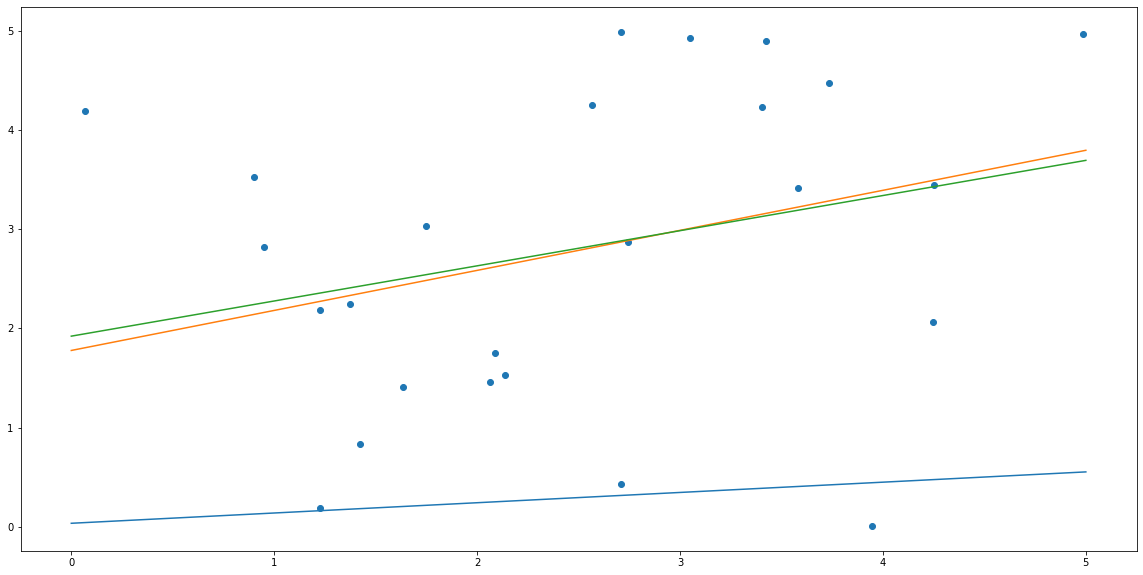

In [14]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, False, 25)
lin_rate_test_list = np.arange(1e-4, 2e-4, 1e-4)
linear.test_stoch_grad(make_point(0, 0), lin_rate_test_list)
linear.test_minibatch(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))
linear.test_grad(make_point(0, 0), lin_rate_test_list)
linear.show()

green - GD  
orange - minibatch GD (5 summands)  
blue - SGD


,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,189.159181,62.274982,47.436680,23,3156,11002
1,0.00010,126.923971,51.446876,47.436681,14,3583,5500
2,0.00015,99.128955,58.722607,47.436679,20,3334,3667
3,0.00020,130.786480,50.477083,47.436679,193,4567,2750
4,0.00025,98.932883,58.684458,47.436681,161,735,2199
5,0.00030,98.124446,47.498201,47.436679,125,10808,1833
6,0.00035,151.243004,47.441837,47.436678,34,8569,1571
7,0.00040,148.876056,47.449202,47.436680,114,11341,1374
8,0.00045,74.545000,47.479474,47.436681,27,8244,1221
9,0.00050,58.649882,48.516946,47.436679,22,14942,1099


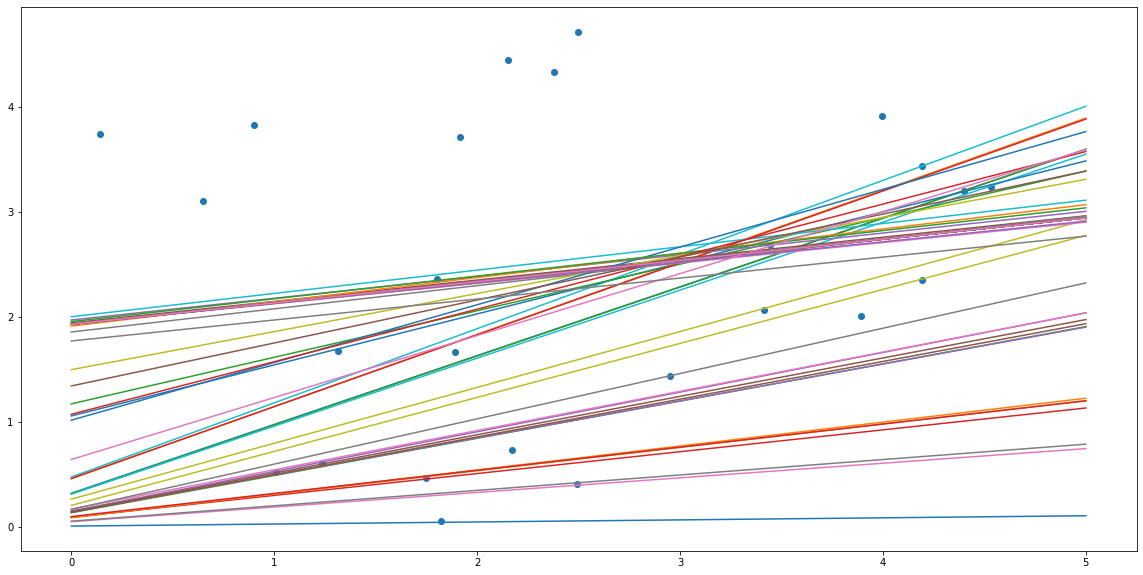

In [15]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, False, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,0.637247,0.251265,0.000600,4875,1489,7810
1,0.00010,0.617996,0.321457,0.000600,2433,890,3905
2,0.00015,0.612194,0.277088,0.000600,1637,1262,2603
3,0.00020,0.702270,0.282919,0.000598,1210,914,1953
4,0.00025,0.581546,0.255750,0.000599,992,553,1562
5,0.00030,0.509641,0.263615,0.000598,875,997,1302
6,0.00035,0.519164,0.168108,0.000597,693,1077,1116
7,0.00040,0.759849,0.289266,0.000599,607,504,976
8,0.00045,0.556385,0.202354,0.000597,554,221,868
9,0.00050,0.645759,0.274473,0.000597,552,266,781


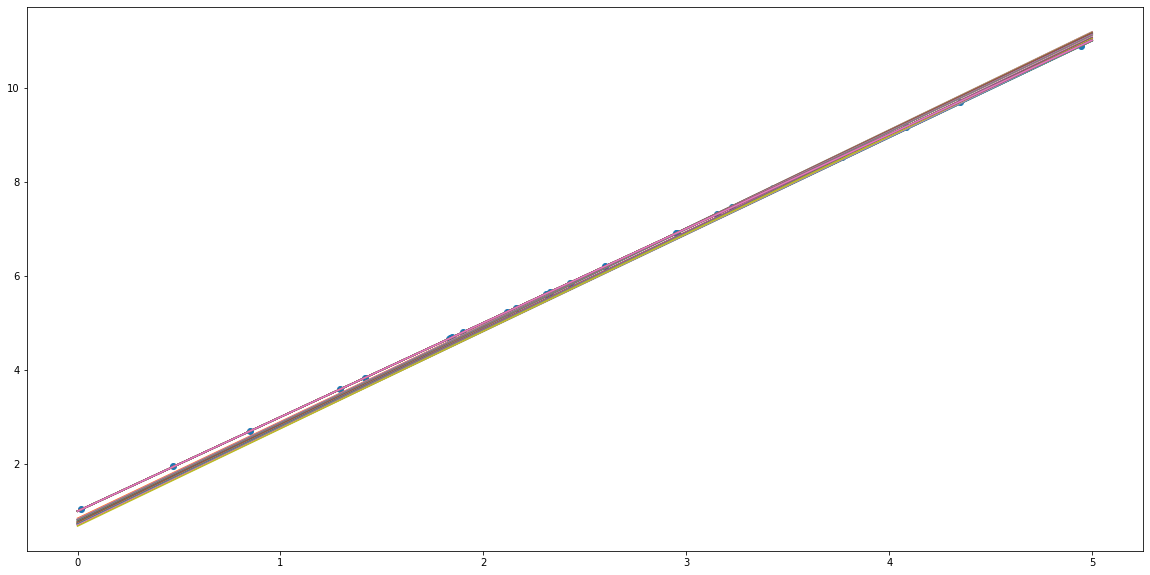

In [16]:
linear = Linear_Regression(0, 5, Mode.POINTS_ON_LINE, False, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

<h5>Задание 2</h5>

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,62.099175,0.193612,0.000100,4492,5166,2806
1,0.00010,88.073620,1.012265,0.000099,1267,3003,1402
2,0.00015,98.151431,0.229576,0.000099,805,1481,934
3,0.00020,47.461451,0.228559,0.000099,754,1685,700
4,0.00025,110.076072,0.112873,0.000098,344,1521,560
5,0.00030,37.077587,0.060171,0.000098,967,1269,466
6,0.00035,47.070151,0.040589,0.000099,342,967,399
7,0.00040,55.479172,0.043959,0.000098,205,932,349
8,0.00045,56.573485,0.083113,0.000098,299,676,310
9,0.00050,100.090397,0.135325,0.000096,414,798,279


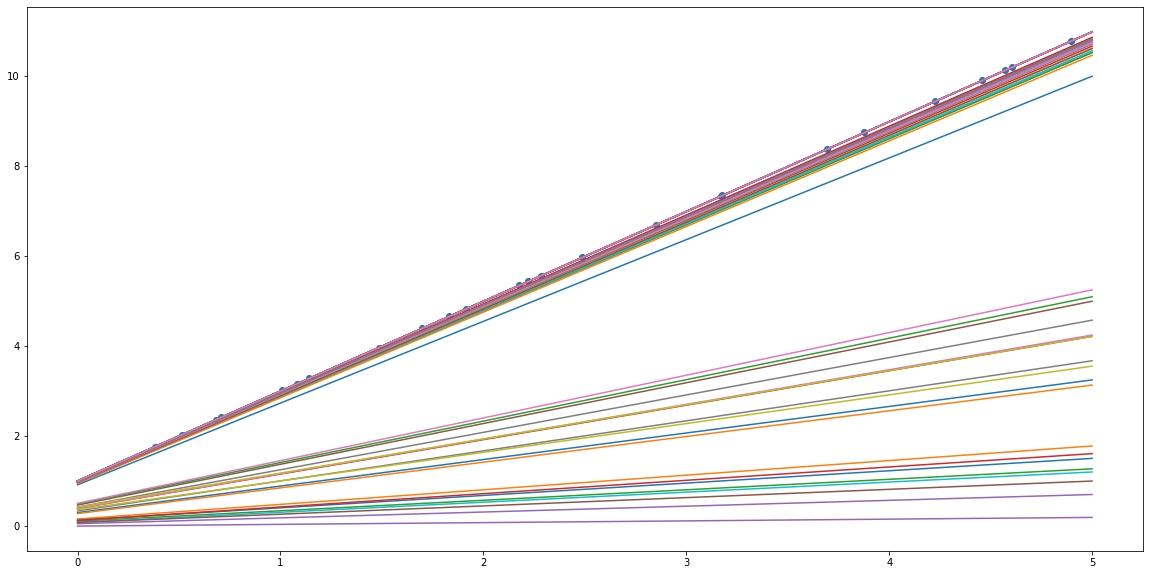

In [17]:
linear = Linear_Regression(0, 5, Mode.POINTS_ON_LINE, True, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,174.587482,49.658325,49.416383,212,2461,2816
1,0.00010,175.508242,52.978446,49.416382,144,9671,1407
2,0.00015,174.707302,49.464219,49.416383,83,1035,937
3,0.00020,172.360185,49.427010,49.416383,54,4393,702
4,0.00025,170.654389,49.426751,49.416381,67,2197,562
5,0.00030,172.768141,49.423282,49.416380,38,3712,468
6,0.00035,160.791929,49.429865,49.416379,104,654,401
7,0.00040,168.966322,49.432252,49.416382,130,1111,350
8,0.00045,164.674772,49.472175,49.416381,91,5352,311
9,0.00050,176.413344,49.927622,49.416379,48,551,280


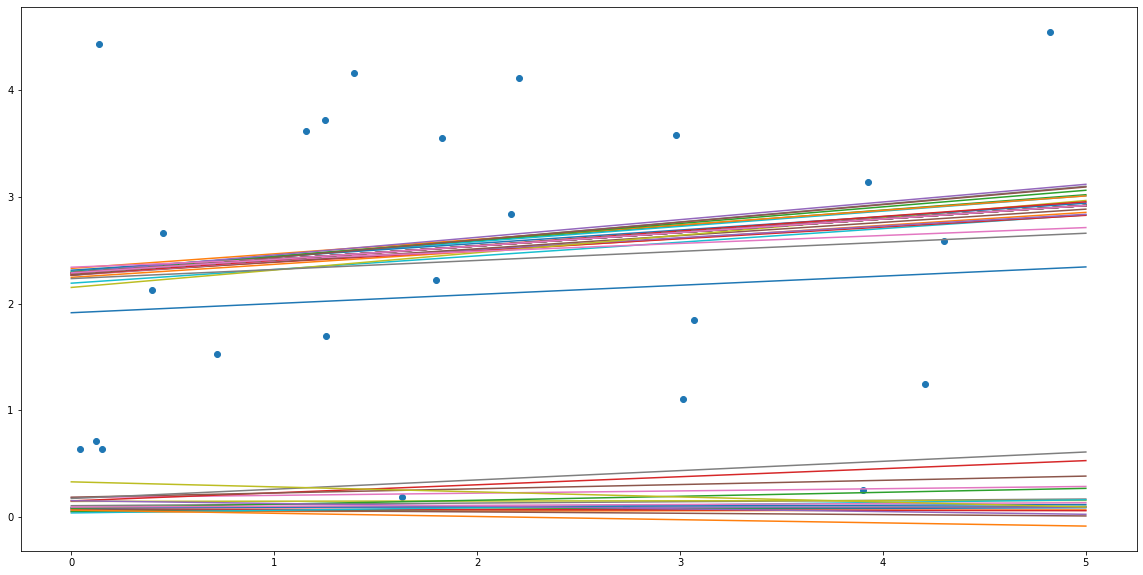

In [18]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, True, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

### Задание 3


In [19]:
import time
import enum
from memory_profiler import profile
%load_ext memory_profiler

In [20]:
stdType = 'float64'

M = 30
spread = 6

def scalarProd(X, B):
    return np.sum(X * B)

In [21]:
bAct = [random.randint(0, spread), random.randint(-spread, spread)]
bAct = np.array(bAct, dtype=stdType)

print(bAct)
XGlobal = []
YGlobal = []
for ind in range(M):
    X = np.array([1, ind])
    rand_delta = random.randint(-spread, spread)
    Y_act = scalarProd(X, bAct) + 0.5 * rand_delta
    YGlobal.append(Y_act)
    XGlobal.append(np.array(X))
XGlobal = np.array(XGlobal, dtype=stdType)
YGlobal = np.array(YGlobal)

[4. 3.]


In [22]:
def performSGD(batch, optimType, drawing, lr, eps):
    bStart = np.array([0, 0], dtype=stdType)
    YCur = np.array([0] * M, dtype=stdType)
    global calculations
    start = time.time()
    calculations = 0
    bFinal, errors, YFinal, iterations = gradientDescent(batch, XGlobal, YGlobal, YCur, bStart, lr, eps, optimType)
    print()
    print(optimType)
    print("numOfBatches:                   ", batch)
    # print("calculated coefficients: ", bFinal)
    print("number of calculations: ", calculations)
    print("number of gradient iterations:    ", iterations)
    print("time of execution: ", (time.time() - start) * 1000, "ms")
    if drawing:
        draw_graph(XGlobal, YGlobal, YFinal, batch, optimType)
        draw_errors_graphic(errors, iterations, batch, optimType)

In [23]:
def calcError(first, second):
    return np.sum((first - second)**2) / M

def shouldStop(prev, cur, eps):
    return abs(prev - cur) < eps

class OptimType(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

def gradientDescent(batch, XGlobal, YGlobal, YCur, BCur, lr, eps, optimType):
    gammaMult = 0.9
    beta1 = 0.9
    beta2 = 0.999
    previousError = 0
    grad = np.array([0, 0], dtype=stdType)
    mAdam = np.array([0, 0], dtype=stdType)
    vAdam = np.array([0, 0], dtype=stdType)
    errors = []
    previousGradient = np.array([0, 0], dtype=stdType)
    iterations = 0
    global calculations
    while True:
        nums = np.array(random.sample(list(range(M)), batch))

        calcDelta = 0
        if optimType == OptimType.none:
            grad = gradient(nums, XGlobal, YCur, YGlobal)
        elif optimType == OptimType.momentum:
            grad = gradient(nums, XGlobal, YCur, YGlobal)
            grad += gammaMult * previousGradient
            calcDelta = 1
        elif optimType == OptimType.Nesterov:
            BPrev = BCur - lr * previousGradient
            YRNew = [scalarProd(XGlobal[i], BPrev) for i in range(M)]
            grad = gradient(nums, XGlobal, np.array(YRNew), YGlobal)
            grad += gammaMult * previousGradient
            calcDelta = 2 + M
        elif optimType == OptimType.AdaGrad:
            grad = gradient(nums, XGlobal, YCur, YGlobal)
            newGrad = previousGradient + np.square(grad)
            newGrad = np.divide(grad, np.sqrt(abs(newGrad + eps)))
            grad = newGrad
            calcDelta = 2
        elif optimType == OptimType.Adam:
            grad = gradient(nums, XGlobal, YCur, YGlobal)
            mAdam = beta1 * mAdam + (1 - beta1) * grad
            vAdam = beta2 * vAdam + (1 - beta2) * np.square(grad)
            m = mAdam / (1 - beta1)
            v = vAdam / (1 - beta2)
            grad = m / np.sqrt(abs(v + eps))
            calcDelta = 5
        elif optimType == OptimType.RMSProp:
            grad = gradient(nums, XGlobal, YCur, YGlobal)
            newGrad = gammaMult * previousGradient + (1 - gammaMult) * np.square(grad)
            newGrad = np.divide(grad, np.sqrt(abs(newGrad + eps)))
            grad = newGrad
            calcDelta = 2
            
        calculations += calcDelta
        BCur -= lr * grad
        YCur = [scalarProd(XGlobal[i], BCur) for i in range(M)]
        if shouldStop(previousError, calcError(YGlobal, YCur), eps):
            # print(optimType, " прерван")
            break
        previousError = calcError(YGlobal, YCur)
        previousGradient = grad
        errors.append(previousError)
        iterations += 1
    return BCur, errors, YCur, iterations

def gradient(nums, XGlobal, YCur, YGlobal):
    global calculations
    grad = []
    for i in range(2):
        xi = 0
        for k in range(len(nums)):
            xi += XGlobal[nums[k]][i] * (YCur[nums[k]] - YGlobal[nums[k]])
            calculations = calculations + 1
        xi *= 2
        xi /= M
        grad.append(xi)
    return np.array(grad)

Графики

In [24]:
def draw_graph(XM, YM, YF, batch, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    title = 'linear regression: numOfBatches=' + str(batch) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


def draw_errors_graphic(E, iterations, batch, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    it = np.linspace(0, iterations, iterations)
    plt.plot(it, E)
    title = 'error vizualization: numOfBatches=' + str(batch) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()

Сравнение алгоритмов



OptimType.none
numOfBatches:                    30
number of calculations:  75600
number of gradient iterations:     1259
time of execution:  417.32096672058105 ms


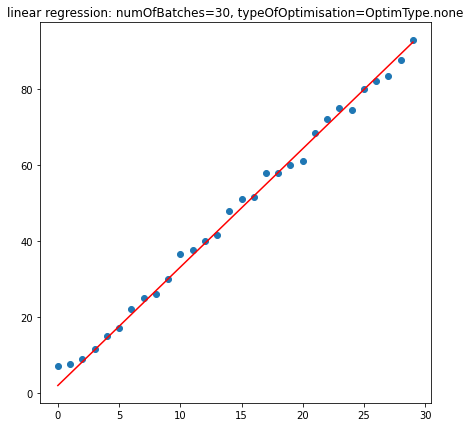

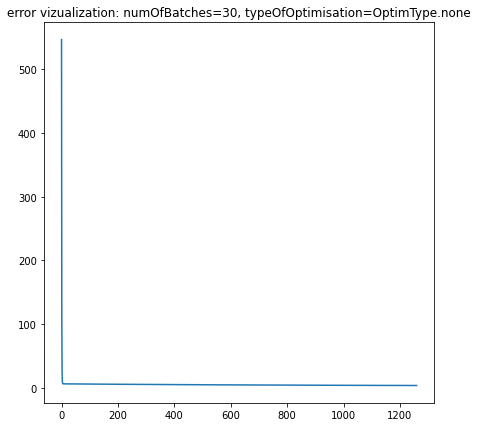

peak memory: 149.71 MiB, increment: 4.46 MiB

OptimType.momentum
numOfBatches:                    30
number of calculations:  6405
number of gradient iterations:     104
time of execution:  39.55888748168945 ms


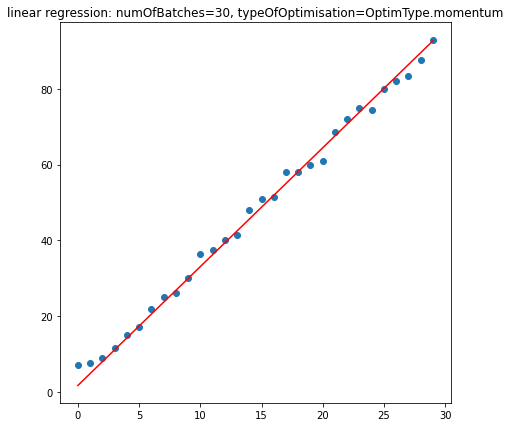

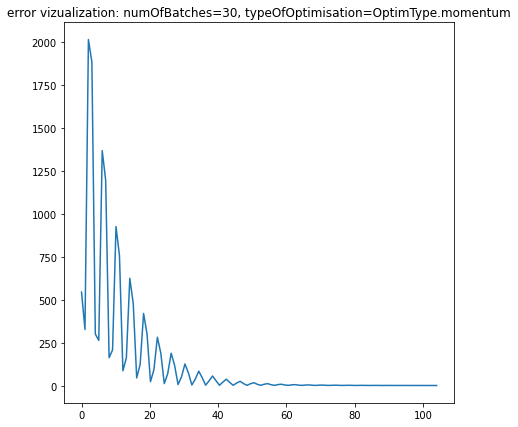

peak memory: 151.08 MiB, increment: 1.61 MiB

OptimType.Nesterov
numOfBatches:                    30
number of calculations:  31648
number of gradient iterations:     343
time of execution:  181.94103240966797 ms


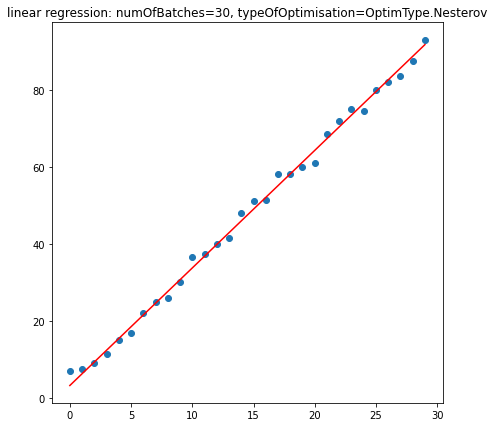

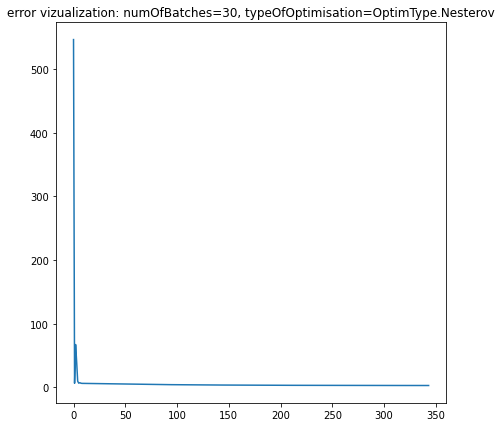

peak memory: 138.44 MiB, increment: 0.00 MiB

OptimType.RMSProp
numOfBatches:                    30
number of calculations:  59830
number of gradient iterations:     964
time of execution:  333.4791660308838 ms


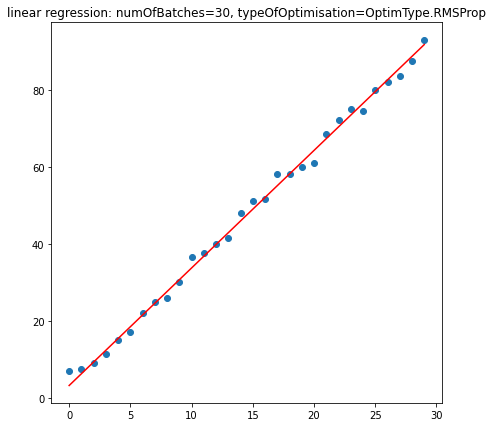

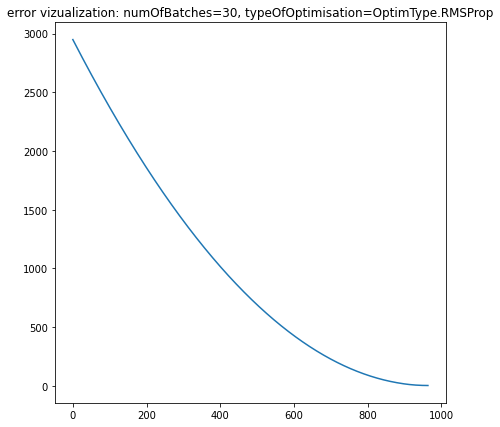

peak memory: 138.27 MiB, increment: 3.34 MiB

OptimType.AdaGrad
numOfBatches:                    30
number of calculations:  189534
number of gradient iterations:     3056
time of execution:  1193.8717365264893 ms


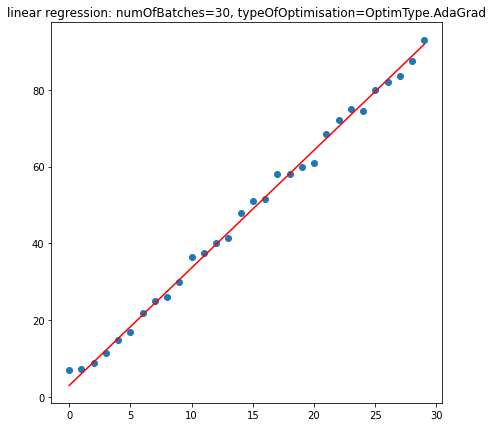

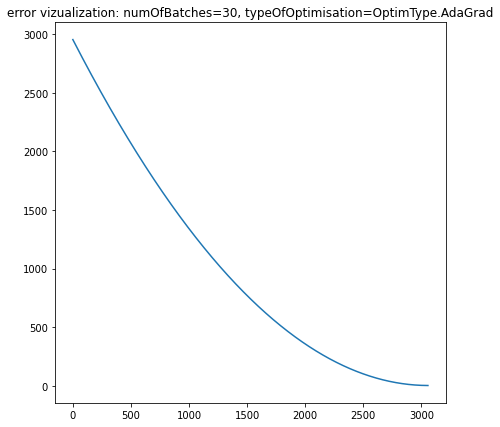

peak memory: 138.45 MiB, increment: 0.25 MiB

OptimType.Adam
numOfBatches:                    30
number of calculations:  758615
number of gradient iterations:     11670
time of execution:  4277.554988861084 ms


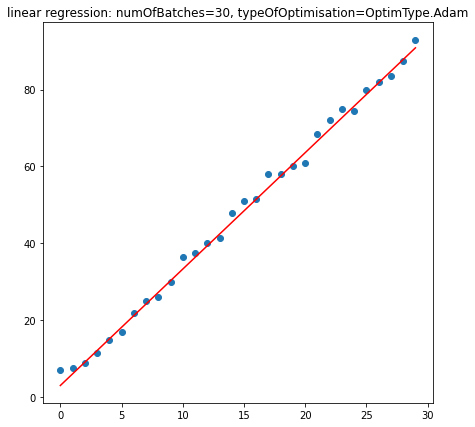

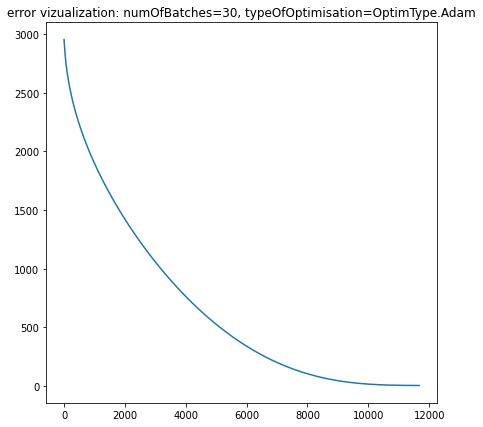

peak memory: 137.66 MiB, increment: 0.04 MiB


In [25]:
# none = 0
# momentum = 1
# Nesterov = 2
# RMSProp = 3
# AdaGrad = 4
# Adam = 5

m_eps = 1e-3
lr = 1e-3
%memit performSGD(M, OptimType.none, True, lr, m_eps)
%memit performSGD(M, OptimType.momentum, True, lr, m_eps)
%memit performSGD(M, OptimType.Nesterov, True, lr, m_eps)
%memit performSGD(M, OptimType.RMSProp, True, lr, m_eps)
%memit performSGD(M, OptimType.AdaGrad, True, lr, m_eps)
%memit performSGD(M, OptimType.Adam, True, lr, m_eps)

In [26]:
m_eps = 1e-4
lr = 1e-4

%memit performSGD(int(M / 3), OptimType.none, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.momentum, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.Nesterov, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.RMSProp, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.AdaGrad, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.Adam, False, lr, m_eps)


OptimType.none
numOfBatches:                    10
number of calculations:  5980
number of gradient iterations:     298
time of execution:  83.25505256652832 ms

OptimType.none
numOfBatches:                    10
number of calculations:  5920
number of gradient iterations:     295
time of execution:  85.01386642456055 ms
peak memory: 134.93 MiB, increment: -0.09 MiB

OptimType.momentum
numOfBatches:                    10
number of calculations:  2835
number of gradient iterations:     134
time of execution:  40.82083702087402 ms

OptimType.momentum
numOfBatches:                    10
number of calculations:  2688
number of gradient iterations:     127
time of execution:  38.8789176940918 ms
peak memory: 134.80 MiB, increment: -0.06 MiB

OptimType.Nesterov
numOfBatches:                    10
number of calculations:  14456
number of gradient iterations:     277
time of execution:  135.55216789245605 ms

OptimType.Nesterov
numOfBatches:                    10
number of calculations:  9672

In [27]:
m_eps = 1e-4
lr = 1e-3

%memit performSGD(int(M / 2), OptimType.none, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.momentum, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.Nesterov, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.RMSProp, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.AdaGrad, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.Adam, False, lr, m_eps)


OptimType.none
numOfBatches:                    15
number of calculations:  2190
number of gradient iterations:     72
time of execution:  28.670072555541992 ms

OptimType.none
numOfBatches:                    15
number of calculations:  5280
number of gradient iterations:     175
time of execution:  75.6988525390625 ms
peak memory: 135.16 MiB, increment: 0.00 MiB

OptimType.momentum
numOfBatches:                    15
number of calculations:  4495
number of gradient iterations:     144
time of execution:  62.795162200927734 ms

OptimType.momentum
numOfBatches:                    15
number of calculations:  21638
number of gradient iterations:     697
time of execution:  299.40295219421387 ms
peak memory: 135.16 MiB, increment: 0.00 MiB

OptimType.Nesterov
numOfBatches:                    15
number of calculations:  14074
number of gradient iterations:     226
time of execution:  156.81934356689453 ms

OptimType.Nesterov
numOfBatches:                    15
number of calculations:  135